# 🧠 Alzheimer's Disease Classification

In [1]:
import os
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

🕸️ A Convolutional Neural Network (CNN) model is used here to classify brain MRIs into normal, very-mild, mild and moderate Alzheimer classes. The data in total consists of 6400 images.

Developed as part of a project work for the **UCS 1603 Introduction to Machine Learning** Course. 📖

Authors:
* Shashanka Venkatesh  - 18 5001 145
* Suraj Jain           - 18 5001 177
* Vishakan Subramanian - 18 5001 196
* Vishnu Krishnan      - 18 5001 200

**We recommend the use of a GPU Accelerator to reduce the load on the CPU and to run the notebook faster.**

### Importing the necessary libraries

### Data Pre-Processing

In [2]:
base_dir = "D:/Download/Alzheimer_s Dataset/"  # 原本的阿茲海默資料夾資料夾內有 train 和 test兩個資料夾
root_dir = "D:/study/Alzheimer_s Dataset/"  # 要跑的資料夾，需要先自行創建
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = work_dir

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:

print(WORK_DIR)

D:/study/Alzheimer_s Dataset/dataset


In [5]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


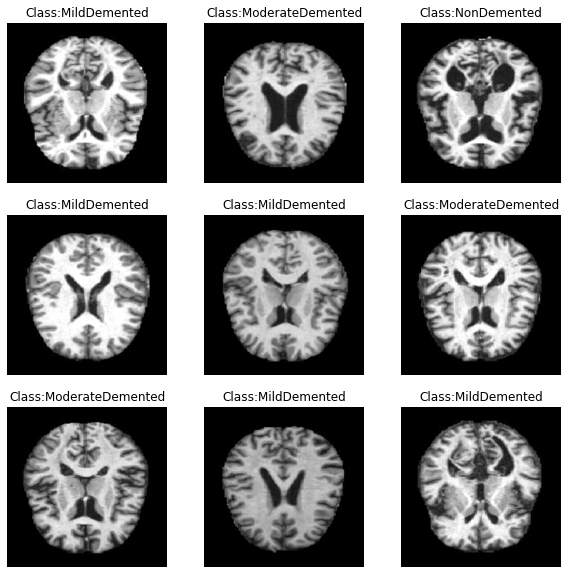

In [6]:
from random import randint
import numpy as np
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset 

print(train_data.shape, train_labels.shape)

(6400, 224, 224, 3) (6400, 4)


In [9]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 224, 224, 3) (12800, 4)


In [10]:
#Splitting the data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
"""
np.save('test_data', test_data)
np.save('test_labels', test_labels)  這裡用不到
np.save('val_data', val_data)
np.save('val_labels', val_labels)
np.save('train_data', train_data)
np.save('train_labels', train_labels)
"""


"\nnp.save('test_data', test_data)\nnp.save('test_labels', test_labels)\nnp.save('val_data', val_data)\nnp.save('val_labels', val_labels)\nnp.save('train_data', train_data)\nnp.save('train_labels', train_labels)\n"

### Constructing a Convolutional Neural Network Architecture

In [12]:

from tensorflow.keras.applications import MobileNet
base_model = MobileNet(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

17235968/17225924 [==============================] - 2s 0us/step


In [13]:
for layer in base_model.layers:
    layer.trainable=False

In [14]:
# Building Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Activation 
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [15]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              102762496 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8

In [16]:
from tensorflow.keras import metrics
import keras.backend as K

### Training & Testing the Model

In [17]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),  
      metrics.AUC(name='auc'),
        f1_score,
]

In [19]:
# Model Compile 
from tensorflow.keras import optimizers
OPT    = optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# Defining Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = './mobile_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [21]:
model_history=model.fit(train_data, train_labels,
                        validation_data=(val_data, val_labels),
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
256/256 [==============================] - ETA: 0s - loss: 0.7194 - accuracy: 0.8669 - precision: 0.7490 - recall: 0.7030 - auc: 0.9243 - f1_score: 0.7235
Epoch 00001: val_auc improved from -inf to 0.97213, saving model to .\mobile_best_weights.hdf5
256/256 [==============================] - 260s 1s/step - loss: 0.7194 - accuracy: 0.8669 - precision: 0.7490 - recall: 0.7030 - auc: 0.9243 - f1_score: 0.7235 - val_loss: 0.4129 - val_accuracy: 0.9240 - val_precision: 0.8550 - val_recall: 0.8379 - val_auc: 0.9721 - val_f1_score: 0.8463
Epoch 2/10
256/256 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9391 - precision: 0.8847 - recall: 0.8696 - auc: 0.9817 - f1_score: 0.8769
Epoch 00002: val_auc improved from 0.97213 to 0.98761, saving model to .\mobile_best_weights.hdf5
256/256 [==============================] - 266s 1s/step - loss: 0.3147 - accuracy: 0.9391 - precision: 0.8847 - recall: 0.8696 - auc: 0.9817 - f1_score: 0.8769 - val_loss: 0.2657 - val_ac

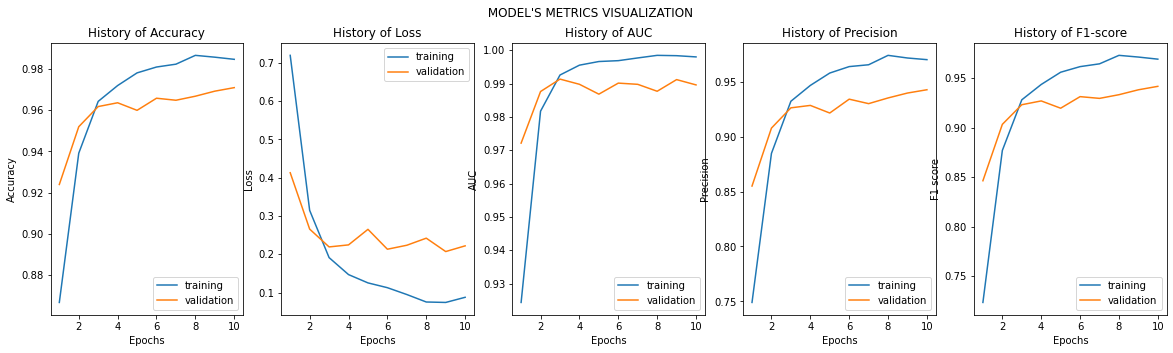

In [22]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],
               model_history.history['f1_score'],model_history.history['val_f1_score']
              )

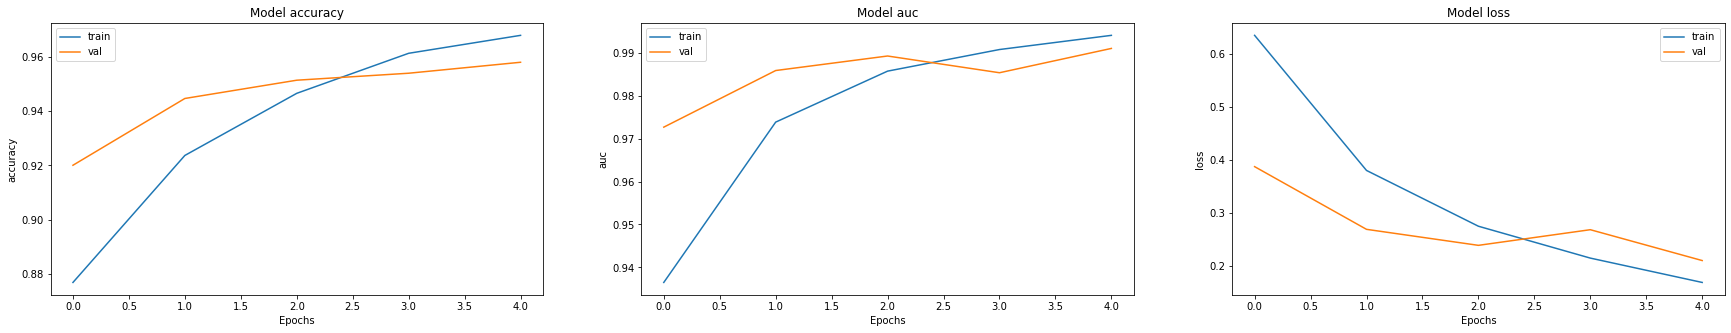

In [27]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(model_history.history[metric])
    ax[i].plot(model_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [28]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 34s 430ms/step - loss: 0.2265 - accuracy: 0.9699 - precision: 0.9409 - recall: 0.9387 - auc: 0.9898 - f1_score: 0.9398
Testing Accuracy: 96.99%


In [24]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [25]:
#Print the classification report of the tested data
from sklearn.metrics import classification_report, confusion_matrix
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.97      0.98      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.91      0.89      0.90       662
ModerateDemented       0.88      0.89      0.89       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



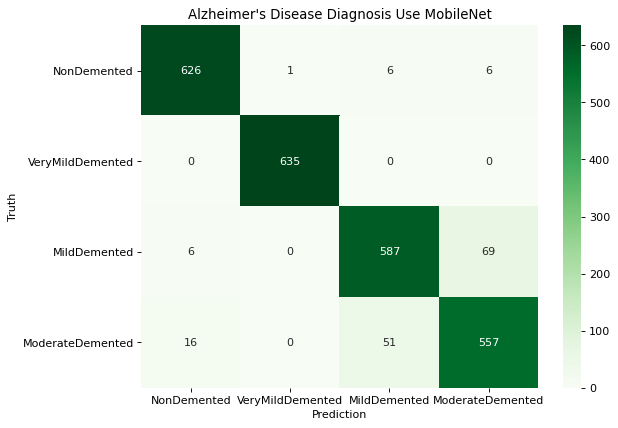

In [27]:
#Plot the confusion matrix to understand the classification in detail

import seaborn as sns
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis Use MobileNet')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [30]:
model.save("smote_mobile.h5")

**Please check out the notebook here: 
[Inception V3 Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-inceptionv3)**